In [2]:
from pathlib import Path
import requests


path = Path("data")
img_path = path / "pizza_steak_sushi"

if img_path.is_dir():
	print(f"{img_path} already exist")
else:
	img_path.mkdir(
		parents=True,
		exist_ok=True,
	)

data/pizza_steak_sushi already exist


In [ ]:
with open(path / "pizza_steak_sushi.zip", "wb") as f:
	req = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/data/pizza_steak_sushi.zip")
	f.write(req.content)
	print("Download completed")

In [3]:
import zipfile


with zipfile.ZipFile(path / "pizza_steak_sushi.zip", "r") as zp:
	zp.extractall(img_path)
	print("Extracted data..")

Extracted data..


In [4]:
from PIL import Image

train_img_paths = list(img_path.glob("train/*/*"))
test_img_paths = list(img_path.glob("test/*/*"))

train_img_paths, test_img_paths
len(train_img_paths), len(test_img_paths)

(225, 75)

In [36]:
from torchvision import transforms

combined_transforms = transforms.Compose([
	transforms.Resize(size=(64, 64)),
	transforms.AugMix(),
	transforms.AutoAugment(),
	transforms.ToTensor()
])

In [37]:
combined_transforms(Image.open(train_img_paths[0])).shape

torch.Size([3, 64, 64])

In [38]:
import torch

train_data = [(combined_transforms(Image.open(x)),  0 if x.parent.stem=='pizza' else (1 if x.parent.stem=='steam' else 2)) for x in train_img_paths]

test_data = [(combined_transforms(Image.open(x)), 0 if x.parent.stem=='pizza' else (1 if x.parent.stem=='steam' else 2)) for x in test_img_paths]

In [39]:
from torch.utils.data import DataLoader

batch_size = 8
train_loader = DataLoader(
	dataset=train_data,
	batch_size=batch_size,
	shuffle=True,
)
test_loader = DataLoader(
	dataset=test_data,
	batch_size=batch_size
)

In [40]:
from torch import nn
class FoodClassifier(nn.Module):
	def __init__(
		self,
		batch_size:int=8,
		input_channels:int=3,
		hidden_units:int=16,
		output_channels:int=3,
	):
		super().__init__()

		self.batch_size = batch_size
		self.input_channels = input_channels
		self.hidden_units = hidden_units
		self.output_channels = output_channels

		self.input_stack = nn.Sequential(
			nn.Conv2d(
				in_channels=input_channels,
				out_channels=hidden_units,
				kernel_size=2,
				stride=1,
				padding=0,
			),
			nn.ReLU(),
			nn.MaxPool2d(
				kernel_size=2,
			)
		)
		self.hidden_stack0 = nn.Sequential(
			nn.Conv2d(
				in_channels=hidden_units,
				out_channels=hidden_units,
				kernel_size=2,
				stride=1,
				padding=0,
			),
			nn.ReLU(),
			nn.MaxPool2d(
				kernel_size=2,
			),
			nn.Conv2d(
				in_channels=hidden_units,
				out_channels=hidden_units,
				kernel_size=2,
				stride=1,
				padding=0,
			),
			nn.MaxPool2d(
				kernel_size=2,
			),
			nn.Conv2d(
				in_channels=hidden_units,
				out_channels=hidden_units,
				kernel_size=2,
				stride=1,
				padding=0,
			),
			nn.MaxPool2d(
				kernel_size=2,
			),
		)
		self.output_stack = nn.Sequential(
			nn.Flatten(),
			nn.ReLU(),
			nn.Linear(
				in_features=hidden_units*3*3,
				out_features=output_channels,
			)
		)
	def forward(self, x: torch.Tensor) -> torch.Tensor:
		# x = self.input_stack(x)
		# print(x.shape)
		# x = self.hidden_stack0(x)
		# print(x.shape)
		# x = self.output_stack(x)
		# print(x.shape)
		# return x
		return self.output_stack(self.hidden_stack0(self.input_stack(x)))
	def accuracy(self, preds: torch.Tensor, real: torch.Tensor) -> float:
		return torch.eq(preds.argmax(dim=1), real).sum().item()/self.batch_size


In [56]:
from torchinfo import summary


mdl = FoodClassifier(
	batch_size=batch_size,
	input_channels=3,
	hidden_units=16,
	output_channels=3,
)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
	params=mdl.parameters(),
	lr=0.001,
)
# summary(mdl)

In [69]:
epochs = 10

for epoch in range(epochs):
	for batch, (x, y) in enumerate(train_loader):
		# y=y.unsqueeze(dim=1)
		mdl.train()
		
		preds = mdl(x)
		loss = loss_fn(preds, y)
		optimizer.zero_grad()
		loss.backward()
		optimizer.step()
	mdl.eval()
	with torch.inference_mode():
		test_loss, test_acc = 0, 0
		for test_x, test_y in test_loader:
			# test_y = test_y.unsqueeze(dim=1)
			test_preds = mdl(test_x)
			test_loss += loss_fn(test_preds, test_y)
			test_acc += mdl.accuracy(test_preds, test_y)
		test_loss /= len(test_loader)
		test_acc /= len(test_loader)
print(f"epoch:{epoch} acc:{test_acc*100:.2f}% loss:{test_loss:.2f}")

epoch:9 acc:62.50% loss:0.67


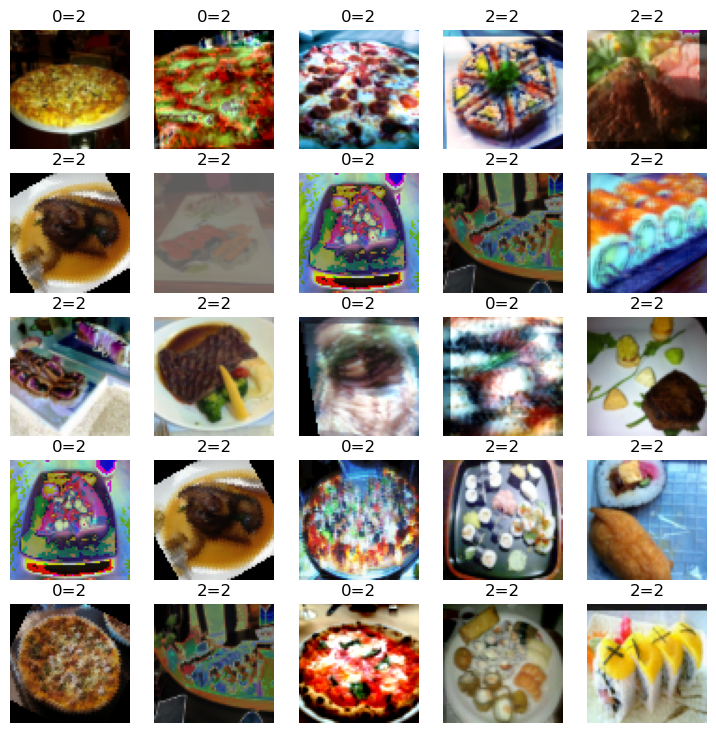

In [70]:
from matplotlib import pyplot as plt

mdl.eval()
fig = plt.figure(figsize=(9, 9))
for i in range(1,26):
	random_number = torch.randint(0,len(test_data),size=(1,))
	random_img, random_lbl = test_data[random_number.item()]
	with torch.inference_mode():
		prediction = mdl(random_img.unsqueeze(dim=0)).argmax(dim=1).unsqueeze(dim=1).item()

	random_img = random_img.permute([1, 2, 0])
	fig.add_subplot(5, 5, i)
	plt.imshow(random_img)
	plt.title(f"{random_lbl}={prediction}")
	plt.axis(False)